In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
ppd_df = pd.read_csv("policedata/ppd_complaints.csv")

In [21]:
display(ppd_df.head())

,complaint_id,date_received,district_occurrence,general_cap_classification,summary
0,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1..."
1,15-0002,2015-01-05,1900,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 8..."
2,15-0003,2015-01-05,1800,LACK OF SERVICE,"According to the complainant, on 1-1-15 at 7:0..."
3,15-0004,2015-01-06,3900,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 2..."
4,15-0005,2015-01-07,3900,PHYSICAL ABUSE,"According to the complainant, on 1-2-15 at 1:3..."


In [22]:
# Add date of complaint
date_pattern = r"(\d{1,2}-\d{1,2}-\d{2,4})" #parentheses is to treat all characters as a "group", making extract work
complaint_str_series = ppd_df['summary'].str.extract(date_pattern, expand=False) #expand=False to get series
complaint_str_series.replace("2-29-18","03-01-18",inplace=True) #replace faulty leap year day
ppd_df['date_of_complaint'] = pd.to_datetime(complaint_str_series)

Number of complaints: 3317

Complaints over time


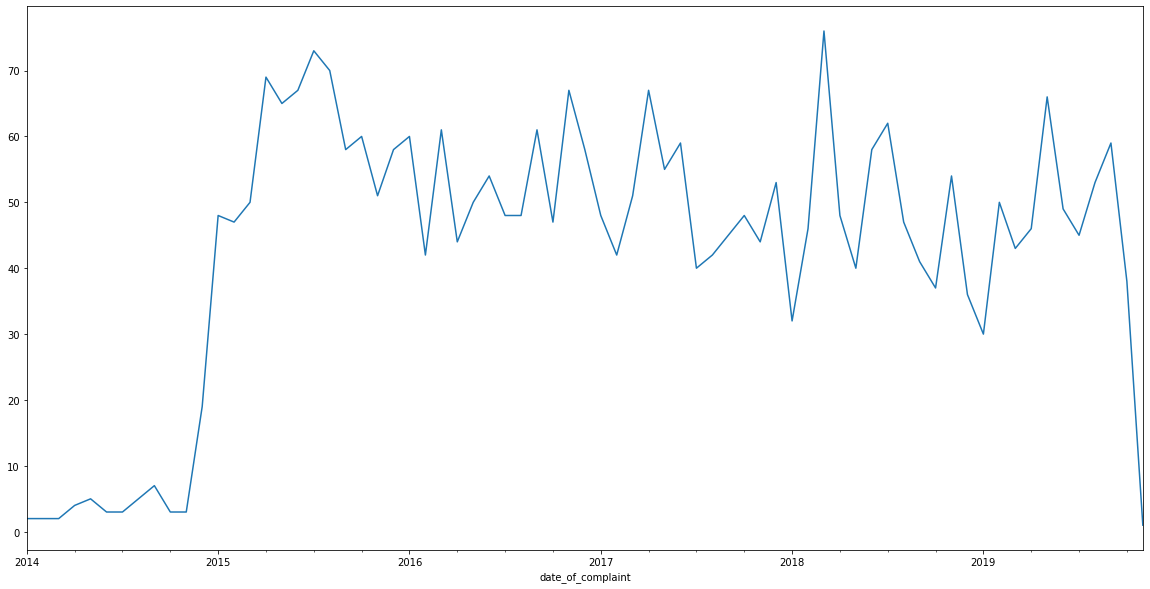

Complaints by district


1500                  264
3500                  258
1900                  235
2500                  234
1800                  221
1400                  207
600                   186
2200                  180
1200                  164
2400                  161
200                   146
3900                  146
900                   137
800                   130
1600                  116
300                   103
1700                   81
700                    79
100                    62
2600                   59
500                    44
7700                   20
2300                    5
400                     3
Other Jurisdiction      3
9                       1
Name: district_occurrence, dtype: int64

Complaints by classification
 DEPARTMENTAL VIOLATIONS       844
 LACK OF SERVICE               742
 PHYSICAL ABUSE                517
 VERBAL ABUSE                  351
 UNPROFESSIONAL CONDUCT        224
 NON-INVESTIGATORY INCIDENT    171
 HARASSMENT                    162
 CRIMINAL ALLEGATION           143
 CIVIL RIGHTS COMPLAINT         97
 DOMESTIC                       41
 SEXUAL CRIME/MISCONDUCT        11
 FALSIFICATION                  10
 DRUGS                           4
Name: general_cap_classification, dtype: int64


In [23]:
# Basic information and visualizations
print("Number of complaints: {}\n".format(ppd_df.shape[0]))

print("Complaints over time")
# optionally, exclude the first few years
complaints_over_time_series = ppd_df[ppd_df['date_of_complaint']>"01-01-2014"].groupby('date_of_complaint').size()
#complaints_over_time_series = ppd_df.groupby('date_of_complaint').size().asfreq(freq="d",fill_value=0)
display(complaints_over_time_series.groupby(pd.Grouper(freq="M")).sum().plot(figsize=(20,10)))
plt.show()

print("Complaints by district")
display(ppd_df['district_occurrence'].value_counts())

print("Complaints by classification")
print(ppd_df['general_cap_classification'].value_counts())

In [24]:
disciplines_df = pd.read_csv("policedata/ppd_complaint_disciplines.csv")

In [25]:
disciplines_df.head()

,complaint_id,officer_id,po_race,po_sex,po_assigned_unit,allegations_investigated,investigative_findings,disciplinary_findings
0,15-0001,23701040.0,white,male,1500 15TH DISTRICT,Departmental Violation,No Sustained Findings,Not Applicable
1,15-0001,86142007.0,white,male,1500 15TH DISTRICT,Departmental Violation,Sustained Finding,Training/Counseling
2,15-0001,86142007.0,white,male,1500 15TH DISTRICT,Departmental Violation,No Sustained Findings,Not Applicable
3,15-0001,23701040.0,white,male,1500 15TH DISTRICT,Verbal Abuse,No Sustained Findings,Not Applicable
4,15-0002,NaN,NaN,NaN,NaN,Departmental Violation,No Sustained Findings,Not Applicable


In [26]:
# Basic counts
for col in ['po_race','po_sex','allegations_investigated','investigative_findings','disciplinary_findings']:
    print(col)
    display(disciplines_df[col].value_counts())

po_race


white     4235
black     2233
latino     702
asian      172
other       61
indian       5
Name: po_race, dtype: int64

po_sex


male      6293
female    1115
Name: po_sex, dtype: int64

allegations_investigated


Departmental Violation                           2559
Lack of Service                                  1439
Verbal Abuse                                      898
Physical Abuse                                    875
Investigation OnGoing                             542
Unprofessional Conduct                            514
No C.A.P. Investigation                           242
Harassment                                        227
Criminal Allegation                               219
Civil Rights Complaint                            155
Referred to Other Agency/C.A.P. Investigation      75
Domestic                                           39
Falsification                                      18
Sexual Crime/Misconduct                            17
Other Misconduct                                   15
Disciplinary Code Violation                        11
Drugs                                               4
Name: allegations_investigated, dtype: int64

investigative_findings


No Sustained Findings    5788
Sustained Finding        1277
Pending                   542
Not Applicable            242
Name: investigative_findings, dtype: int64

disciplinary_findings


Not Applicable         6044
Training/Counseling     802
Pending                 793
Guilty Finding          162
No Guilty Findings       48
Name: disciplinary_findings, dtype: int64

In [27]:
# Merge the datasets, keeping rows with a complaint id a 
complaint_key = ['complaint_id','officer_id','allegations_investigated']
merged_df = ppd_df.merge(disciplines_df,on='complaint_id',how='inner').drop_duplicates()

In [72]:
# Add column for # of rws that appeared for each complaint key
num_complaints_df = disciplines_df.drop_duplicates()\
    .groupby(complaint_key).size()
print("Number of unique allegations made (specific complaint, officer and allegation): ",str(num_complaints_df.shape[0]))
multiple_complaints_df = num_complaints_df.rename("num_complaint_rows")

# Make dataframe which will contain final investigative outcome for each complaint key
outcome_df = merged_df.merge(multiple_complaints_df, 
                             how='inner',
                             left_on=complaint_key,
                             right_index=True)
assert(all(~outcome_df.duplicated()))
# display(outcome_df)

# Find all complaints where at least one row had a Sustained Finding, and store those keys into a set
sustained_findings_df = outcome_df[outcome_df['investigative_findings']=='Sustained Finding']
print('Number of unique allegations made with investigative outcome "Sustained Findings":',
      str(sustained_findings_df.shape[0]))
#display(sustained_findings_df)
assert(all(~sustained_findings_df.duplicated()))
assert(all(~sustained_findings_df[complaint_key].duplicated()))
sustained_findings_keys = {",".join(str(x) for x in arr) for arr in sustained_findings_df[complaint_key].values}

# Find all complaints where at least one row had a Guilty Finding disciplinary finding 
guilty_df = outcome_df[outcome_df['disciplinary_findings'] == 'Guilty Finding']
print('Number of unique allegations made with disciplinary outcome "Guilty Finding":',
      str(guilty_df.shape[0]))
guilty_finding_keys = {",".join(str(x) for x in arr) for arr in guilty_df[complaint_key].values}

# Remove duplicate rows for each complaint in the outcome dataframe, then add column with 
# True if the investigation had sustained findings
outcome_df = outcome_df.drop_duplicates(subset=complaint_key)\
    .drop(['investigative_findings','disciplinary_findings'],axis=1)
key_column = [",".join(str(x) for x in arr) for arr in outcome_df[complaint_key].values]
outcome_df['complaint_key'] = key_column
outcome_df['sustained_investigative_finding'] = outcome_df['complaint_key'].isin(sustained_findings_keys)
outcome_df['guilty_disciplinary_finding'] = outcome_df['complaint_key'].isin(guilty_finding_keys)
display(outcome_df)

Number of unique allegations made (specific complaint, officer and allegation):  6701
Number of unique allegations made with investigative outcome "Sustained Findings": 1088
Number of unique allegations made with disciplinary outcome "Guilty Finding": 123


,complaint_id,date_received,district_occurrence,general_cap_classification,summary,date_of_complaint,officer_id,po_race,po_sex,po_assigned_unit,allegations_investigated,num_complaint_rows,complaint_key,sustained_investigative_finding,guilty_disciplinary_finding
0,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1...",2014-12-31,23701040.0,white,male,1500 15TH DISTRICT,Departmental Violation,1,"15-0001,23701040.0,Departmental Violation",False,False
1,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1...",2014-12-31,86142007.0,white,male,1500 15TH DISTRICT,Departmental Violation,2,"15-0001,86142007.0,Departmental Violation",True,False
3,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1...",2014-12-31,23701040.0,white,male,1500 15TH DISTRICT,Verbal Abuse,1,"15-0001,23701040.0,Verbal Abuse",False,False
5,15-0003,2015-01-05,1800,LACK OF SERVICE,"According to the complainant, on 1-1-15 at 7:0...",2015-01-01,22284833.0,black,male,1800 18TH DISTRICT,Lack of Service,1,"15-0003,22284833.0,Lack of Service",False,False
6,15-0003,2015-01-05,1800,LACK OF SERVICE,"According to the complainant, on 1-1-15 at 7:0...",2015-01-01,53846151.0,white,male,1800 18TH DISTRICT,Lack of Service,1,"15-0003,53846151.0,Lack of Service",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7844,19-0564,2019-10-31,1400,CRIMINAL ALLEGATION,"According to the complainant, on 10-3-19 at 6:...",2019-10-03,91161043.0,white,male,6600 NORTHWEST DETECTIVE,Investigation OnGoing,1,"19-0564,91161043.0,Investigation OnGoing",False,False
7845,19-0564,2019-10-31,1400,CRIMINAL ALLEGATION,"According to the complainant, on 10-3-19 at 6:...",2019-10-03,37387773.0,white,male,6600 NORTHWEST DETECTIVE,Investigation OnGoing,1,"19-0564,37387773.0,Investigation OnGoing",False,False
7846,19-0565,2019-10-31,1900,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 09-27-19 at 9...",2019-09-27,31795389.0,black,male,1900 19TH DISTRICT,Investigation OnGoing,1,"19-0565,31795389.0,Investigation OnGoing",False,False
7847,19-0565,2019-10-31,1900,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 09-27-19 at 9...",2019-09-27,77173730.0,latino,male,1600 16TH DISTRICT,Investigation OnGoing,1,"19-0565,77173730.0,Investigation OnGoing",False,False


In [75]:
complainant_demographics_df = pd.read_csv('policedata/ppd_complainant_demographics.csv').set_index('complaint_id')
display(complainant_demographics_df.head())
outcome_df = outcome_df.merge(complainant_demographics_df, left_on='complaint_id',right_index=True)

,complainant_sex,complainant_race,complainant_age
complaint_id,,,
15-0001,male,black,20.0
15-0002,male,black,24.0
15-0003,male,white,45.0
15-0004,female,black,46.0
15-0005,male,black,35.0


In [78]:
#outcome_to_test = "guilty_disciplinary_finding"
outcome_to_test = 'sustained_investigative_finding'
print('Outcome to test: {}'.format(outcome_to_test))
print("Total number of complaints: {0}\nTotal number of successful complaints: {1}\nPercent of complaints which succeeded: {2:.2f}% "\
     .format(outcome_df.shape[0],outcome_df[outcome_to_test].sum(),
             100*outcome_df[outcome_to_test].sum()/outcome_df.shape[0]))
for column in ['complainant_sex','complainant_race','po_race','po_sex','allegations_investigated']:
    print("Fraction of complaints with true outcome by {}".format(column))
    print(outcome_df[outcome_df[outcome_to_test]==True][column].value_counts(normalize=True))
    print("Fraction of complaints with false outcome by {}".format(column))
    print(outcome_df[outcome_df[outcome_to_test]==False][column].value_counts(normalize=True))
        

Outcome to test: sustained_investigative_finding
Total number of complaints: 7052
Total number of successful complaints: 1160
Percent of complaints which succeeded: 16.45% 
Fraction of complaints with true outcome by complainant_sex
male      0.566845
female    0.433155
Name: complainant_sex, dtype: float64
Fraction of complaints with false outcome by complainant_sex
male      0.562812
female    0.437188
Name: complainant_sex, dtype: float64
Fraction of complaints with true outcome by complainant_race
black           0.660513
white           0.222564
latino          0.098462
asian           0.007179
multi ethnic    0.006154
other           0.005128
Name: complainant_race, dtype: float64
Fraction of complaints with false outcome by complainant_race
black           0.682960
white           0.197815
latino          0.087790
asian           0.019360
other           0.007092
indian          0.003259
multi ethnic    0.001150
middle east     0.000575
Name: complainant_race, dtype: float64
Fra

In [77]:
for column in ['complainant_sex','complainant_race','po_race','po_sex','allegations_investigated']:
    print("% of successful complaints by {}".format(column))
    for column_possibility in outcome_df[column].unique():
        print("When {} = {}".format(column,column_possibility))
        if pd.isna(column_possibility):
            print(outcome_df[outcome_df[column].isna()][outcome_to_test].value_counts())
            print(outcome_df[outcome_df[column].isna()][outcome_to_test].value_counts(normalize=True))
        else:
            print(outcome_df[outcome_df[column]==column_possibility][outcome_to_test].value_counts())
            print(outcome_df[outcome_df[column]==column_possibility][outcome_to_test].value_counts(normalize=True))

% of successful complaints by complainant_sex
When complainant_sex = male
False    3833
True       69
Name: guilty_disciplinary_finding, dtype: int64
False    0.982317
True     0.017683
Name: guilty_disciplinary_finding, dtype: float64
When complainant_sex = female
False    2964
True       59
Name: guilty_disciplinary_finding, dtype: int64
False    0.980483
True     0.019517
Name: guilty_disciplinary_finding, dtype: float64
When complainant_sex = nan
False    123
True       4
Name: guilty_disciplinary_finding, dtype: int64
False    0.968504
True     0.031496
Name: guilty_disciplinary_finding, dtype: float64
% of successful complaints by complainant_race
When complainant_race = black
False    4152
True       55
Name: guilty_disciplinary_finding, dtype: int64
False    0.986927
True     0.013073
Name: guilty_disciplinary_finding, dtype: float64
When complainant_race = white
False    1215
True       34
Name: guilty_disciplinary_finding, dtype: int64
False    0.972778
True     0.027222
Name

In [79]:
outcome_df['officer_id'].value_counts()

29180642.0    22
40251428.0    20
66221391.0    20
47524892.0    19
64290544.0    19
              ..
54661371.0     1
87549116.0     1
44419538.0     1
31812726.0     1
10551607.0     1
Name: officer_id, Length: 2901, dtype: int64

In [92]:
outcome_df

,complaint_id,date_received,district_occurrence,general_cap_classification,summary,date_of_complaint,officer_id,po_race,po_sex,po_assigned_unit,allegations_investigated,num_complaint_rows,complaint_key,sustained_investigative_finding,guilty_disciplinary_finding,complainant_sex,complainant_race,complainant_age
0,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1...",2014-12-31,23701040.0,white,male,1500 15TH DISTRICT,Departmental Violation,1,"15-0001,23701040.0,Departmental Violation",False,False,male,black,20.0
1,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1...",2014-12-31,86142007.0,white,male,1500 15TH DISTRICT,Departmental Violation,2,"15-0001,86142007.0,Departmental Violation",True,False,male,black,20.0
3,15-0001,2015-01-05,1500,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 12-31-14 at 1...",2014-12-31,23701040.0,white,male,1500 15TH DISTRICT,Verbal Abuse,1,"15-0001,23701040.0,Verbal Abuse",False,False,male,black,20.0
5,15-0003,2015-01-05,1800,LACK OF SERVICE,"According to the complainant, on 1-1-15 at 7:0...",2015-01-01,22284833.0,black,male,1800 18TH DISTRICT,Lack of Service,1,"15-0003,22284833.0,Lack of Service",False,False,male,white,45.0
6,15-0003,2015-01-05,1800,LACK OF SERVICE,"According to the complainant, on 1-1-15 at 7:0...",2015-01-01,53846151.0,white,male,1800 18TH DISTRICT,Lack of Service,1,"15-0003,53846151.0,Lack of Service",False,False,male,white,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7844,19-0564,2019-10-31,1400,CRIMINAL ALLEGATION,"According to the complainant, on 10-3-19 at 6:...",2019-10-03,91161043.0,white,male,6600 NORTHWEST DETECTIVE,Investigation OnGoing,1,"19-0564,91161043.0,Investigation OnGoing",False,False,female,black,39.0
7845,19-0564,2019-10-31,1400,CRIMINAL ALLEGATION,"According to the complainant, on 10-3-19 at 6:...",2019-10-03,37387773.0,white,male,6600 NORTHWEST DETECTIVE,Investigation OnGoing,1,"19-0564,37387773.0,Investigation OnGoing",False,False,female,black,39.0
7846,19-0565,2019-10-31,1900,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 09-27-19 at 9...",2019-09-27,31795389.0,black,male,1900 19TH DISTRICT,Investigation OnGoing,1,"19-0565,31795389.0,Investigation OnGoing",False,False,female,black,NaN
7847,19-0565,2019-10-31,1900,DEPARTMENTAL VIOLATIONS,"According to the complainant, on 09-27-19 at 9...",2019-09-27,77173730.0,latino,male,1600 16TH DISTRICT,Investigation OnGoing,1,"19-0565,77173730.0,Investigation OnGoing",False,False,female,black,NaN


In [91]:
print("\n".join(outcome_df[outcome_df['officer_id']==29180642.0]['summary']))
print(outcome_df[outcome_df['officer_id']==29180642.0]['sustained_investigative_finding'].sum())
print(outcome_df[outcome_df['officer_id']==29180642.0]['guilty_disciplinary_finding'].sum())

According to the complainant, on 4-2-16 at 12:30am, they were harassed by officers assigned to the 35th District.
According to the complainant, on 4-2-16 at 12:30am, they were harassed by officers assigned to the 35th District.
According to the complainant, on 4-29-16 at 7:20am, they were harassed by officers assigned to the 35th District.
According to the complainant, on 6-6-16 at 1:15am, they were verbally abused and threatened by an officer assigned to the 35th District.
According to the complainant, on 9-7-16 at 12:45am, they were verbally abused by officers assigned to the 35th District.
According to the complainant, on 9-7-16 at 12:45am, they were verbally abused by officers assigned to the 35th District.
According to the complainant, on 10-21-17 at 10:00pm, they were improperly stopped by officers assigned to the 35th District.
According to the complainant, on 1-30-18 at 7:00pm, they were verbally abused by officers assigned to the 35th District.
According to the complainant, on